<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Hyperparameter Tuning

## *Data Science Unit 4 Sprint 2 Assignment 4*

## Your Mission, should you choose to accept it...

To hyperparameter tune and extract every ounce of accuracy out of this telecom customer churn dataset: <https://drive.google.com/file/d/1dfbAsM9DwA7tYhInyflIpZnYs7VT-0AQ/view> 

## Requirements

- Load the data
- Clean the data if necessary (it will be)
- Create and fit a baseline Keras MLP model to the data.
- Hyperparameter tune (at least) the following parameters:
 - batch_size
 - training epochs
 - optimizer
 - learning rate (if applicable to optimizer)
 - momentum (if applicable to optimizer)
 - activation functions
 - network weight initialization
 - dropout regularization
 - number of neurons in the hidden layer
 
 You must use Grid Search and Cross Validation for your initial pass of the above hyperparameters
 
 Try and get the maximum accuracy possible out of this data! You'll save big telecoms millions! Doesn't that sound great?


In [1]:
import pandas as pd
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRogyepiDBKBhNVrgweTm-gKQXmJtMAyW5SuavkiOlFheQodPMwwWLOF-DObja6I8ax5UztyLK5DGfP/pub?output=csv'

In [2]:
!wget https://docs.google.com/spreadsheets/d/e/2PACX-1vRogyepiDBKBhNVrgweTm-gKQXmJtMAyW5SuavkiOlFheQodPMwwWLOF-DObja6I8ax5UztyLK5DGfP/pub?output=csv

--2019-11-03 00:23:23--  https://docs.google.com/spreadsheets/d/e/2PACX-1vRogyepiDBKBhNVrgweTm-gKQXmJtMAyW5SuavkiOlFheQodPMwwWLOF-DObja6I8ax5UztyLK5DGfP/pub?output=csv
Resolving docs.google.com (docs.google.com)... 172.217.6.206, 2607:f8b0:4006:815::200e
Connecting to docs.google.com (docs.google.com)|172.217.6.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘pub?output=csv’

pub?output=csv          [ <=>                ] 954.58K  --.-KB/s    in 0.1s    

2019-11-03 00:23:24 (8.35 MB/s) - ‘pub?output=csv’ saved [977488]



In [3]:
!head pub?output=csv

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,

In [4]:
import pandas as pd
df = pd.read_csv('pub?output=csv')

In [5]:
#lets get a percentage count of how often people churn to set a baseline
df['Churn'].value_counts(normalize=True)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [6]:
#converting the target to a 0/1 categorical

df['Churn'] = df['Churn'].replace({'Yes':1, 'No':0})

In [7]:
#digging up unit 2 notes on working with tabular data
#offhand I know understanding how many unique values there is in a dataset is imortant for feature engineering

for col in df.columns: print(col, df[col].nunique())

customerID 7043
gender 2
SeniorCitizen 2
Partner 2
Dependents 2
tenure 73
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4
MonthlyCharges 1585
TotalCharges 6530
Churn 2


In [8]:
#Dropping Customer ID
X = df.drop(columns=['Churn', 'customerID']).values
y = df['Churn'].values

In [20]:
#ordinal encoding will map the many low cardinality fields into a numerical representation
import category_encoders as ce
ord_enc = ce.OrdinalEncoder()

#scalar encoding will transform our inputs to be prepared for a neural network
from sklearn.preprocessing import StandardScaler
scaler  = StandardScaler()

X = ord_enc.fit_transform(X)
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=1337)

In [21]:
import pandas as pd
import numpy
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 1337
numpy.random.seed(seed)

# load dataset


# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(19, input_dim=19, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
# batch_size = [10, 20, 40, 60, 80, 100]
# param_grid = dict(batch_size=batch_size, epochs=epochs)


In [26]:
# define the grid search parameters
param_grid = {'batch_size': [10, 25, 50],
              'epochs': [20]}

# Create Grid Search
#MAKE SURE JOBS =1, MAKING JOBS =-1 DOES NOT PLAY NICELY WITH THE KERAS WRAPPER IT DOES NOT PARRELIZE WELL
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

Best: 0.7341915892521029 using {'batch_size': 10, 'epochs': 20}
Means: 0.7341915892521029, Stdev: 0.010842345219373606 with: {'batch_size': 10, 'epochs': 20}
Means: 0.7341915892521029, Stdev: 0.010842345219373606 with: {'batch_size': 25, 'epochs': 20}
Means: 0.7341915892521029, Stdev: 0.010842345219373606 with: {'batch_size': 50, 'epochs': 20}


In [ ]:
#batch size of 10 was best

In [27]:
# define the grid search parameters
param_grid = {'batch_size': [10],
              'epochs': [20,50,100]}

# Create Grid Search
#MAKE SURE JOBS =1, MAKING JOBS =-1 DOES NOT PLAY NICELY WITH THE KERAS WRAPPER IT DOES NOT PARRELIZE WELL
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

Best: 0.7341915892521029 using {'batch_size': 10, 'epochs': 20}
Means: 0.7341915892521029, Stdev: 0.010842345219373606 with: {'batch_size': 10, 'epochs': 20}
Means: 0.7341915892521029, Stdev: 0.010842345219373606 with: {'batch_size': 10, 'epochs': 50}
Means: 0.7341915892521029, Stdev: 0.010842345219373606 with: {'batch_size': 10, 'epochs': 100}


In [43]:
#my second pass of models shows an optimal combination of batch size 10 and epochs of 20

updated_model = create_model()

opt = updated_model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=10,
                        validation_split=.1,
                        verbose=True)

Train on 4753 samples, validate on 529 samples
Epoch 1/20
4753/4753 [==============================] - 2s 437us/sample - loss: nan - accuracy: 0.6903 - val_loss: nan - val_accuracy: 0.7221
Epoch 2/20
4753/4753 [==============================] - 1s 212us/sample - loss: nan - accuracy: 0.7355 - val_loss: nan - val_accuracy: 0.7221
Epoch 3/20
4753/4753 [==============================] - 1s 186us/sample - loss: nan - accuracy: 0.7355 - val_loss: nan - val_accuracy: 0.7221
Epoch 4/20
4753/4753 [==============================] - 1s 197us/sample - loss: nan - accuracy: 0.7355 - val_loss: nan - val_accuracy: 0.7221
Epoch 5/20
4753/4753 [==============================] - 1s 213us/sample - loss: nan - accuracy: 0.7355 - val_loss: nan - val_accuracy: 0.7221
Epoch 6/20
4753/4753 [==============================] - 1s 241us/sample - loss: nan - accuracy: 0.7355 - val_loss: nan - val_accuracy: 0.7221
Epoch 7/20
4753/4753 [==============================] - 1s 232us/sample - loss: nan - accuracy: 0.735

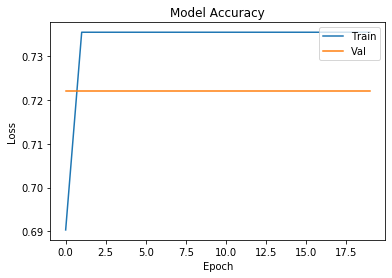

In [44]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(opt.history['accuracy'])
plt.plot(opt.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [45]:
scores = updated_model.evaluate(X_test, y_test)

print('Neural Network ACC: ', scores[1])

1761/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [65]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam


def create_model_with_drops():
    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    
    adam = Adam(lr=0.001)

    
    
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model

model_with_drops = KerasClassifier(build_fn=create_model_with_drops, verbose=1)




In [66]:
final_model = model_with_drops.fit(X, y,
                         epochs=20,
                         batch_size=10,
                         validation_split=.1,
                         verbose=1)

Train on 6338 samples, validate on 705 samples
Epoch 1/20
6338/6338 [==============================] - 2s 352us/sample - loss: nan - accuracy: 0.7340 - val_loss: nan - val_accuracy: 0.7234
Epoch 2/20
6338/6338 [==============================] - 1s 209us/sample - loss: nan - accuracy: 0.7359 - val_loss: nan - val_accuracy: 0.7234
Epoch 3/20
6338/6338 [==============================] - 2s 251us/sample - loss: nan - accuracy: 0.7359 - val_loss: nan - val_accuracy: 0.7234
Epoch 4/20
6338/6338 [==============================] - 1s 212us/sample - loss: nan - accuracy: 0.7359 - val_loss: nan - val_accuracy: 0.7234
Epoch 5/20
6338/6338 [==============================] - 1s 224us/sample - loss: nan - accuracy: 0.7359 - val_loss: nan - val_accuracy: 0.7234
Epoch 6/20
6338/6338 [==============================] - 1s 195us/sample - loss: nan - accuracy: 0.7359 - val_loss: nan - val_accuracy: 0.7234
Epoch 7/20
6338/6338 [==============================] - 1s 179us/sample - loss: nan - accuracy: 0.735

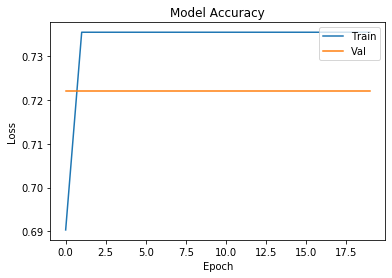

In [67]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.plot(opt.history['accuracy'])
plt.plot(opt.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Stretch Goals:

- Try to implement Random Search Hyperparameter Tuning on this dataset
- Try to implement Bayesian Optimiation tuning on this dataset using hyperas or hyperopt (if you're brave)
- Practice hyperparameter tuning other datasets that we have looked at. How high can you get MNIST? Above 99%?
- Study for the Sprint Challenge
 - Can you implement both perceptron and MLP models from scratch with forward and backpropagation?
 - Can you implement both perceptron and MLP models in keras and tune their hyperparameters with cross validation?